---
FIRST

---

In [1]:
# read it in to inspect it
with open('tinyshakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
print("length of dataset in characters: ", len(text))
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)
print(chars[1])

length of dataset in characters:  1115394

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
 


In [3]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [4]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)

torch.Size([1115394]) torch.int64


In [5]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

---
We now need to make characters into spike trains

---

In [6]:
import numpy as np

def generate_spike_trains(input_data, U_max, U_min, N_sample):
    """
    Generate spike trains using Poisson encoding.
    
    Parameters:
        input_data (numpy.ndarray): Normalized input data (e.g., between U_min and U_max).
        U_max (float): Maximum value of the input range.
        U_min (float): Minimum value of the input range.
        N_sample (int): Number of spike samples.
    
    Returns:
        spike_trains (numpy.ndarray): Generated spike trains (0s and 1s).
    """
    # Calculate average spike interval
    h_k = N_sample * (U_max - input_data) / (U_max - U_min)
    
    # Generate intervals using Poisson distribution
    intervals = np.random.poisson(h_k)
    
    # Generate spike trains
    spike_trains = np.zeros((len(input_data), N_sample))
    for i, interval in enumerate(intervals):
        spike_indices = np.cumsum(np.random.choice(np.arange(1, N_sample + 1), interval, replace=False))
        spike_indices = spike_indices[spike_indices < N_sample]
        spike_trains[i, spike_indices] = 111
    
    return spike_trains


# Example input data
input_data = np.array([0.1, 0.4, 0.7, 0.9])  # Normalized input
U_max = 1.0
U_min = 0.0
N_sample = 100  # Spike sampling times

# Generate spike trains
spikes = generate_spike_trains(input_data, U_max, U_min, N_sample)
print("Generated Spike Trains:")
# print(spikes)


Generated Spike Trains:


In [7]:
# SIMPLEST ENCODING
# each character activate 1 neuron, fixed

def char_to_spike(char):
    """
    One hot encoding of a character
    
    Parameters: 
        char (string): the character to encode
    
    Returns:
        np.array of dimensions (N_sam, 65)   
    """
    spikes = torch.zeros((1, 65))
    spikes[0, char] = 1

    return spikes

print(char_to_spike(0))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


---
Create the reservoire

N_res is the number of neurons in the reservoir

---

In [8]:
import numpy as np
from scipy.sparse import random
from scipy.sparse.linalg import eigs  # For sparse eigenvalue computation

# Parameters
N_res = 1000  # Size of the reservoir (N_res x N_res)
eta = 0.1    # Sparsity degree (10% non-zero entries)

def uniform_rvs(size):
    return np.random.uniform(low=-1.0, high=1.0, size=size)
# Generate a sparse matrix with uniform random values in [-1, 1]
W = random(N_res, N_res, density=eta, format='csr', data_rvs=uniform_rvs)

# Convert to a dense matrix (optional, for visualization or further processing)
W_dense = W.toarray()

#Calculate the max eigenvalue and find the max
max_eigenvalue = eigs(W, k=1, which='LM', return_eigenvectors=False)[0].real

# Normalize W to get W_res
rho = 0.9
W_res = rho * (W / max_eigenvalue)
W_res = torch.from_numpy(W_dense).to(torch.float32)

In [9]:
W_res.dtype

torch.float32

---
BATCH EXAMPLE

---

In [10]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----


In [11]:
def tensor_to_one_hot(input_tensor, num_classes=1000):
    """
    One hot encode all the data in a batch
    """
    batch_size, seq_len = input_tensor.shape

    # Create a zero tensor of shape (batch_size, seq_len, num_classes)
    one_hot_tensor = torch.zeros((batch_size, seq_len, num_classes), dtype=torch.float32)

    # Fill the one-hot tensor
    for i in range(batch_size):
        for j in range(seq_len):
            one_hot_tensor[i, j, input_tensor[i, j]] = 1

    return one_hot_tensor

# Example usage
input_tensor = torch.tensor([[24, 43, 58,  5, 57,  1, 46, 43],
                              [44, 53, 56,  1, 58, 46, 39, 58],
                              [52, 58,  1, 58, 46, 39, 58,  1],
                              [25, 17, 27, 10,  0, 21,  1, 54]])

one_hot_encoded_tensor = tensor_to_one_hot(torch.zeros((1, 1), dtype=torch.long))
print(one_hot_encoded_tensor.shape)

torch.Size([1, 1, 1000])


In [12]:
one_hot_encoded_tensor.dtype    

torch.float32

---
Trainable output layer

---

In [13]:
for i in range(1):
    print(i)

0


In [30]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

class SingleLayerNN(nn.Module):
    def __init__(self, input_size=1000, hidden_size=500 ,output_size=65):
        super(SingleLayerNN, self).__init__()

        # self.linear = nn.Linear(input_size, output_size)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()  # Define the ReLU activation function
    
    def reservoir_forward(self, input, targets=None):


        xb_hot = tensor_to_one_hot(input)
        B, T, C = xb_hot.shape
        output = torch.zeros(B, T, 65)

        if T > 1:
            for b in range(T - 1):
                xb_hot[:, b, :] = torch.atan(xb_hot[:, b, :] @ W_res)
                xb_hot[:, b + 1, :] += xb_hot[:, b, :]
            xb_hot[:, T - 1, :] = torch.atan(xb_hot[:, T - 2, :] @ W_res)
        else:
            xb_hot[:, 0, :] = torch.atan(xb_hot[:, 0, :] @ W_res)

        output, loss = self(xb_hot, targets)

        return output, loss

    def forward(self, x, targets=None):
        
        x = self.linear1(x) # (B, T, C)
        x = self.tanh(x)
        output = self.linear2(x)

        # output = self.linear(x)


        if targets == None:
            loss = None
        else:
            B, T, C = output.shape
            output = output.view(B*T, C) 
            targets = targets.view(B*T)
            loss = F.cross_entropy(output, targets)

        return output, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self.reservoir_forward(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [31]:
model = SingleLayerNN(input_size=1000, output_size=65)

output, loss = model.reservoir_forward(xb, yb)
print(output.shape)
print(loss)

print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))



torch.Size([65536, 65])
tensor(4.2172, grad_fn=<NllLossBackward0>)

$NA$Acnsb FgALJYTLrkFZIEhc,Ro,T$:ITl:AhCbnis
EciEsSsjtOtABE&H&ebxk?coCzAOAAIhUWm,x.vA-a$ WjR.qhmowpW


In [38]:
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-5)

Step 1, Loss: 2.9978878498077393
Step 2, Loss: 3.0033814907073975
Step 3, Loss: 3.0004889965057373
Step 4, Loss: 2.9936470985412598
Step 5, Loss: 2.9929392337799072
Step 6, Loss: 2.998530149459839
Step 7, Loss: 3.001811981201172
Step 8, Loss: 2.9915883541107178
Step 9, Loss: 2.9886581897735596
Step 10, Loss: 3.007965326309204
Step 11, Loss: 3.0033786296844482
Step 12, Loss: 2.9926836490631104
Step 13, Loss: 2.9937071800231934
Step 14, Loss: 2.987462043762207
Step 15, Loss: 2.992145538330078
Step 16, Loss: 2.9944958686828613
Step 17, Loss: 2.9956274032592773
Step 18, Loss: 2.996976852416992
Step 19, Loss: 2.9907920360565186
Step 20, Loss: 2.9913713932037354
Step 21, Loss: 2.9937522411346436
Step 22, Loss: 2.994356632232666
Step 23, Loss: 2.992372989654541
Step 24, Loss: 2.988926410675049
Step 25, Loss: 2.985161304473877
Step 26, Loss: 3.001751184463501
Step 27, Loss: 2.9950640201568604
Step 28, Loss: 2.9845898151397705
Step 29, Loss: 2.991067886352539
Step 30, Loss: 2.9889683723449707
S

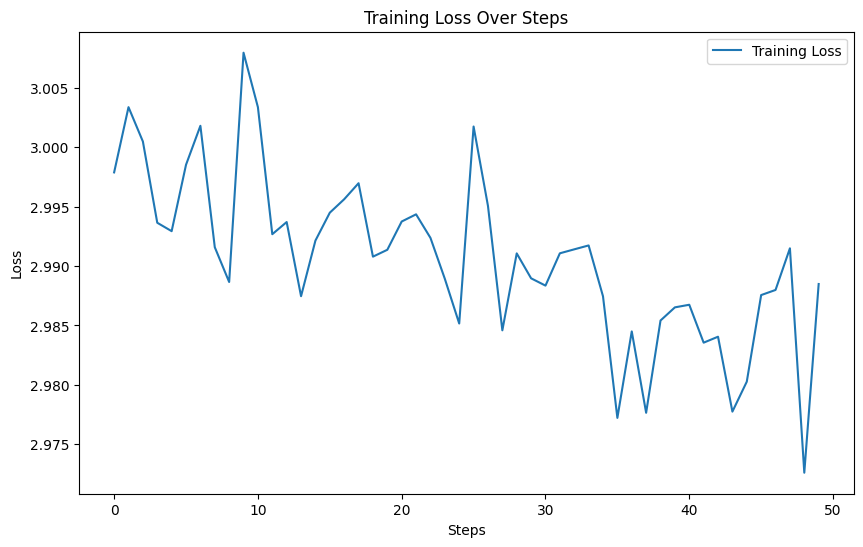

In [40]:
import matplotlib.pyplot as plt

# Initialize a list to store the loss values
loss_values = []

batch_size = 8192
for steps in range(50):  # Increase the number of steps for good results...

    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the loss
    logits, loss = model.reservoir_forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Append the loss value to the list
    loss_values.append(loss.item())

    # Print the loss value
    print(f"Step {steps + 1}, Loss: {loss.item()}")

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Steps')
plt.legend()
plt.show()

In [48]:
import torch

# Create a dense (1, 3000) vector
dense_vector = torch.randn(1, 3000)  # Shape: (1, 3000)

# Create a dense (3000, 3000) matrix with 5% nonzero values
dense_matrix = torch.randn(3000, 3000)  # Start with a dense matrix
mask = torch.rand(3000, 3000) > 0.95  # Keep only 5% of the elements
dense_matrix = dense_matrix * mask  # Apply mask

# Perform the dense matrix multiplication
result_dense = dense_vector @ dense_matrix  # Shape: (1, 3000)

print("Dense Multiplication Result Shape:", result_dense.shape)  # Expected: (1, 3000)

Dense Multiplication Result Shape: torch.Size([1, 3000])


In [49]:
for i in range(1000):
    result = dense_vector @ dense_matrix
    dense_vector = dense_vector + 1

In [50]:
import torch

# Create a dense (1, 3000) vector
dense_vector = torch.randn(1, 3000)  # Shape: (1, 3000)

# Create a dense (3000, 3000) matrix with 5% nonzero values
dense_matrix = torch.randn(3000, 3000)
mask = torch.rand(3000, 3000) > 0.95  # Keep only 5% of the elements
sparse_matrix = (dense_matrix * mask).to_sparse()  # Convert to sparse format

# Perform sparse matrix multiplication
result_sparse = dense_vector @ sparse_matrix  # Shape: (1, 3000)

print("Sparse Multiplication Result Shape:", result_sparse.shape)  # Expected: (1, 3000)


Sparse Multiplication Result Shape: torch.Size([1, 3000])


In [51]:
for i in range(1000):
    result = dense_vector @ sparse_matrix
    dense_vector = dense_vector + 1

In [ ]:
# Calculate the moving average of the loss values
window_size = 10  # You can adjust the window size for smoother/rougher averaging
moving_avg_loss = np.convolve(loss_values, np.ones(window_size)/window_size, mode='valid')

# Plot the moving average of the loss values
plt.figure(figsize=(10, 6))
plt.plot(moving_avg_loss, label='Moving Average Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Moving Average Training Loss Over Steps')
plt.legend()
plt.show()

---
PASS

---

In [ ]:
"""
    
"""